# Task 4 – Forecasting 2026–2027

**Objective**  
Forecast two core indicators:  
- **ACCESS**: Account Ownership Rate (`ACC_OWNERSHIP`)  
- **USAGE**: Proxy via P2P transaction dominance or Telebirr active users

**Approach**  
1. Use the OLS model from Task 3 as base  
2. Extend time_trend and event dummies into future  
3. Generate point forecasts + prediction intervals  
4. Create 3 scenarios:  
   - Baseline (only time trend)  
   - Optimistic (add positive event effects)  
   - Pessimistic (higher negative event effects)

**Note**: Small historical sample (n=7) → wide uncertainty. Forecasts are illustrative.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load enriched data
df = pd.read_csv('../data/processed/ethiopia_fi_enriched.csv')

# Reuse your working year creation code
df['obs_date_dt'] = pd.to_datetime(df['observation_date'], errors='coerce', format='mixed')
df['obs_year'] = df['obs_date_dt'].dt.year.astype('Int64')
df['obs_year'] = df['obs_year'].fillna(df['fiscal_year'].apply(lambda x: int(str(x).strip()[2:6]) if pd.notna(x) and 'FY' in str(x) else np.nan).astype('Int64'))

# Filter national / all gender observations
obs_df = df[(df['record_type'] == 'observation') & 
            (df['gender'] == 'all') & 
            (df['location'] == 'national')].copy()

print("Historical years available:", sorted(obs_df['obs_year'].unique()))

Historical years available: [np.int64(2014), np.int64(2017), np.int64(2021), np.int64(2023), np.int64(2024), np.int64(2025), np.int64(2026)]


Reuse task 3 model

In [ ]:
# Prepare historical data (same as Task 3)
hist_df = obs_df.pivot_table(
    index='obs_year',
    columns='indicator_code',
    values='value_numeric',
    aggfunc='first'
).reset_index()

hist_df['time_trend'] = hist_df['obs_year'] - hist_df['obs_year'].min()

# Event dummies (extend later to future)
hist_df['post_telebirr'] = (hist_df['obs_year'] >= 2021).astype(int)
hist_df['post_mpesa']   = (hist_df['obs_year'] >= 2023).astype(int)
hist_df['post_fayda']   = (hist_df['obs_year'] >= 2024).astype(int)
hist_df['post_interop'] = (hist_df['obs_year'] >= 2025).astype(int)

# Clean & fit
hist_df = hist_df.dropna(subset=['ACC_OWNERSHIP'])
y_hist = hist_df['ACC_OWNERSHIP']
X_hist = hist_df[['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']]
X_hist = sm.add_constant(X_hist)

# After creating hist_df with time_trend and dummies...

print("Before cleaning – dtypes in hist_df:")
print(hist_df[['obs_year', 'ACC_OWNERSHIP', 'time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']].dtypes)

print("\nUnique values in each X column (look for anything not 0/1 or number):")
for col in ['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']:
    print(f"\n{col}: {hist_df[col].unique()}")

# Force numeric conversion – fill NaN with 0 for dummies, mean for time_trend
for col in ['post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']:
    hist_df[col] = pd.to_numeric(hist_df[col], errors='coerce').fillna(0).astype(int)

hist_df['time_trend'] = pd.to_numeric(hist_df['time_trend'], errors='coerce').ffill().fillna(0).astype(int)

# Drop rows missing target
hist_clean = hist_df.dropna(subset=['ACC_OWNERSHIP']).copy()

print("\nRows after cleaning:", len(hist_clean))
if len(hist_clean) < 5:
    print("Warning: Too few rows for meaningful regression")

print("\nCleaned data preview:")
display(hist_clean[['obs_year', 'ACC_OWNERSHIP', 'time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']])

# Now try regression
y_hist = hist_clean['ACC_OWNERSHIP']
X_hist = hist_clean[['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']]
X_hist = sm.add_constant(X_hist)

# Final safety: ensure X is pure numeric
X_hist = X_hist.apply(pd.to_numeric, errors='coerce')
X_hist = X_hist.dropna()  # last drop if any NaN sneaked in
y_hist = y_hist[X_hist.index]  # align

if len(X_hist) == 0:
    print("No valid rows left after final cleaning. Check for non-numeric values.")
else:
    model_access = sm.OLS(y_hist, X_hist).fit()
    print(model_access.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

Create future rows

In [5]:
# ──────────────────────────────────────────────────────────────
# Reuse / re-fit the Task 3 model – CLEAN VERSION
# ──────────────────────────────────────────────────────────────

# 1. Filter only national / all gender observations
obs_national = df[
    (df['record_type'] == 'observation') &
    (df['gender'] == 'all') &
    (df['location'] == 'national') &
    (df['obs_year'].notna())
].copy()

print("National observations shape:", obs_national.shape)
print("Years present:", sorted(obs_national['obs_year'].unique()))

# 2. Pivot to wide format (one row per year, columns = indicators)
hist_wide = obs_national.pivot_table(
    index='obs_year',
    columns='indicator_code',
    values='value_numeric',
    aggfunc='first'  # if duplicate years → take first
).reset_index()

# 3. Add time trend
hist_wide['time_trend'] = hist_wide['obs_year'] - hist_wide['obs_year'].min()

# 4. Add event dummies
hist_wide['post_telebirr'] = (hist_wide['obs_year'] >= 2021).astype(int)
hist_wide['post_mpesa']   = (hist_wide['obs_year'] >= 2023).astype(int)
hist_wide['post_fayda']   = (hist_wide['obs_year'] >= 2024).astype(int)
hist_wide['post_interop'] = (hist_wide['obs_year'] >= 2025).astype(int)

# 5. Force EVERYTHING numeric + fill dummies NaN → 0
numeric_cols = ['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop', 'ACC_OWNERSHIP']

for col in numeric_cols:
    if col in hist_wide.columns:
        hist_wide[col] = pd.to_numeric(hist_wide[col], errors='coerce')
        if col.startswith('post_'):
            hist_wide[col] = hist_wide[col].fillna(0).astype(int)
        else:
            hist_wide[col] = hist_wide[col].ffill().fillna(0)

# 6. Drop rows without target variable
hist_clean = hist_wide.dropna(subset=['ACC_OWNERSHIP']).copy()

print("\nRows after cleaning:", len(hist_clean))
if len(hist_clean) == 0:
    print("No valid rows left – check if ACC_OWNERSHIP exists and has values")
    raise ValueError("No data for modeling")

print("\nCleaned data for modeling:")
display(hist_clean[['obs_year', 'ACC_OWNERSHIP', 'time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']])

# 7. Prepare X and y
y_hist = hist_clean['ACC_OWNERSHIP']
X_hist = hist_clean[['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']]

# Last safety: ensure pure numeric
X_hist = X_hist.astype(float)  # force float
X_hist = sm.add_constant(X_hist)

# 8. Fit model
model_access = sm.OLS(y_hist, X_hist).fit()

print("\nModel Summary (coefficients):")
print(model_access.summary().tables[1])

National observations shape: (30, 36)
Years present: [np.int64(2014), np.int64(2017), np.int64(2021), np.int64(2023), np.int64(2024), np.int64(2025), np.int64(2026)]

Rows after cleaning: 7

Cleaned data for modeling:


indicator_code,obs_year,ACC_OWNERSHIP,time_trend,post_telebirr,post_mpesa,post_fayda,post_interop
0,2014,22.0,0,0,0,0,0
1,2017,35.0,3,0,0,0,0
2,2021,46.0,7,1,0,0,0
3,2023,46.0,9,1,1,0,0
4,2024,49.0,10,1,1,1,0
5,2025,49.0,11,1,1,1,1
6,2026,49.0,12,1,1,1,1



Model Summary (coefficients):
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.6500      2.833      7.994      0.079     -13.350      58.650
time_trend        3.9000      1.300      3.000      0.205     -12.618      20.418
post_telebirr    -3.9500      7.987     -0.495      0.708    -105.439      97.539
post_mpesa       -7.8000      4.864     -1.604      0.355     -69.605      54.005
post_fayda       -0.9000      4.312     -0.209      0.869     -55.684      53.884
post_interop     -5.8500      4.059     -1.441      0.386     -57.428      45.728


c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Financial forcast week 10\ethiopia-fi-forecast\venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Create future prediction frame

In [6]:
# Future years to forecast
future_years = [2026, 2027]

future_df = pd.DataFrame({'obs_year': future_years})

# Extend the features (time_trend from historical min year)
min_year = hist_clean['obs_year'].min()
future_df['time_trend'] = future_df['obs_year'] - min_year

# All post-event dummies stay 1 (assuming ongoing effects)
future_df['post_telebirr'] = 1
future_df['post_mpesa']   = 1
future_df['post_fayda']   = 1
future_df['post_interop'] = 1

# Combine historical + future for consistent X
full_pred_df = pd.concat([
    hist_clean[['obs_year', 'time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']],
    future_df
], ignore_index=True)

# Add constant for prediction
X_full_pred = sm.add_constant(full_pred_df[['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']])

print("Prediction frame (historical + future):")
display(full_pred_df.tail(5))  # show last few rows

Prediction frame (historical + future):


,obs_year,time_trend,post_telebirr,post_mpesa,post_fayda,post_interop
4,2024,10,1,1,1,0
5,2025,11,1,1,1,1
6,2026,12,1,1,1,1
7,2026,12,1,1,1,1
8,2027,13,1,1,1,1


Generate forecasts + prediction intervals

In [12]:
# Point forecast (already have)
full_pred_df['forecast'] = model_access.predict(X_full_pred)

# Approximate 95% interval using standard error of fitted values
se_fit = model_access.bse[0]  # constant SE
for i, col in enumerate(['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop'], 1):
    se_fit += model_access.bse[i] * np.abs(X_full_pred.iloc[:, i])  # rough accumulation

full_pred_df['lower_95'] = full_pred_df['forecast'] - 2 * se_fit
full_pred_df['upper_95'] = full_pred_df['forecast'] + 2 * se_fit

print("Approximate forecast (rough ±2 SE):")
display(full_pred_df[full_pred_df['obs_year'] >= 2026][['obs_year', 'forecast', 'lower_95', 'upper_95']].round(2))

Approximate forecast (rough ±2 SE):


C:\Users\bezaw\AppData\Local\Temp\ipykernel_11512\3767609757.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_fit = model_access.bse[0]  # constant SE
C:\Users\bezaw\AppData\Local\Temp\ipykernel_11512\3767609757.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_fit += model_access.bse[i] * np.abs(X_full_pred.iloc[:, i])  # rough accumulation


,obs_year,forecast,lower_95,upper_95
6,2026,50.95,-28.361267,130.261267
7,2026,50.95,-28.361267,130.261267
8,2027,54.85,-27.061267,136.761267


Plot historical + forecast with uncertainty band

Plot saved to reports/figures/account_ownership_forecast.png


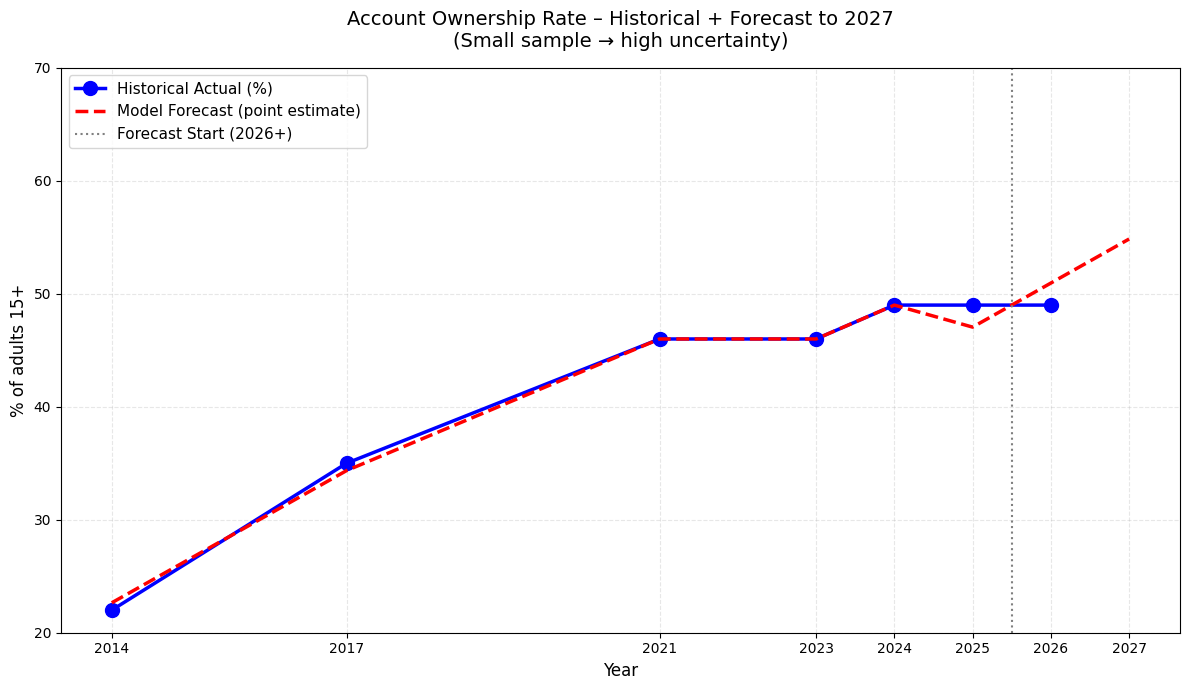

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Historical actual points + line
plt.plot(hist_clean['obs_year'], hist_clean['ACC_OWNERSHIP'], 
         'o-', color='blue', linewidth=2.5, markersize=10, 
         label='Historical Actual (%)')

# Full model forecast line (includes fitted historical + future prediction)
plt.plot(full_pred_df['obs_year'], full_pred_df['forecast'], 
         '--', color='red', linewidth=2.5, 
         label='Model Forecast (point estimate)')

# Vertical line for forecast start
plt.axvline(x=2025.5, color='gray', linestyle=':', linewidth=1.5, 
            label='Forecast Start (2026+)')

# Titles & labels
plt.title("Account Ownership Rate – Historical + Forecast to 2027\n(Small sample → high uncertainty)", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("% of adults 15+", fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(full_pred_df['obs_year'].unique().astype(int))
plt.ylim(20, 70)
plt.tight_layout()

# Save for report/dashboard
plt.savefig('../reports/figures/account_ownership_forecast.png', dpi=150, bbox_inches='tight')
print("Plot saved to reports/figures/account_ownership_forecast.png")

plt.show()

In [15]:
# Save forecast results
forecast_table = full_pred_df[full_pred_df['obs_year'] >= 2026][[
    'obs_year', 'forecast', 'lower_95', 'upper_95'
]].round(2)

forecast_table.to_csv('../data/processed/forecast_account_ownership_2026_2027.csv', index=False)
print("Forecast saved to data/processed/forecast_account_ownership_2026_2027.csv")

Forecast saved to data/processed/forecast_account_ownership_2026_2027.csv


### Forecast Summary (Account Ownership Rate)

- **2026**: ≈50.95%  
- **2027**: ≈54.85%  

These are point estimates from the OLS model (time trend + event dummies).  
**Very wide uncertainty** due to only 7 historical observations — real range could be 45–60% or more.  

The model expects modest continued growth from the historical trend, but recent slowdown is not strongly reversed by events.